In [ ]:
import torch
import pandas as pd
import numpy as np
import gc
import math
from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer, AutoModelForCausalLM
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import userdata, drive
from huggingface_hub import login

In [ ]:
HF_TOKEN = userdata.get('HF_TOKEN')
login(token=HF_TOKEN)
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load model
model_name = "meta-llama/Meta-Llama-3-8B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.pad_token_id = tokenizer.eos_token_id
tokenizer.padding_side = "left"

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.float16,
    device_map="auto"
)
model.config.pad_token_id = tokenizer.pad_token_id
embedder = SentenceTransformer('all-MiniLM-L6-v2')

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
# Load datasets
df_train = pd.read_csv("/content/drive/MyDrive/266/lfud_logic_train.csv")
df_val = pd.read_csv("/content/drive/MyDrive/266/lfud_logic_val.csv")

inputs_train = df_train["input"].tolist()
labels_train = df_train["label"].tolist()

inputs_val = df_val["input"].tolist()
labels_val = df_val["label"].tolist()

# Label mappings
label2id = {
    'faulty generalization': 0, 'false causality': 1, 'circular reasoning': 2,
    'ad populum': 3, 'false dilemma': 4, 'fallacy of relevance': 5,
    'ad hominem': 6, 'appeal to emotion': 7, 'fallacy of extension': 8,
    'fallacy of credibility': 9, 'intentional fallacy': 10, 'deductive fallacy': 11
}
id2label = {v: k for k, v in label2id.items()}

In [60]:
# Prompt and extraction functions
def detect_fallacy_prompt(argument, examples_context=None):
    base_prompt = f"""Analyze the following argument step by step and identify the logical fallacy: {argument}
Choose from the following fallacy types: {', '.join(label2id.keys())}.
Provide a brief explanation of your reasoning, then clearly state the fallacy type.
"""
    if examples_context:
        return f"""Here are some examples of confusing arguments, along with explanations of their logical fallacies. You can refer to them for guidance:
{examples_context}

Now, analyze the next argument:

{base_prompt}"""
    else:
        return base_prompt

def extract_fallacy(response):
    response = response.lower().replace("-", " ")
    words = set(response.split())
    for fallacy in label2id:
        if all(word in words for word in fallacy.lower().split()):
            return fallacy
    return "none"

In [ ]:
# Uncertainty Metrics
def calculate_disagreement(responses):
    labels = [extract_fallacy(r) for r in responses]
    return len(set(labels)) / len(labels), labels

def calculate_entropy(labels):
    counts = pd.Series(labels).value_counts(normalize=True)
    return -np.sum([p * math.log2(p + 1e-10) for p in counts])

def reasoning_consistency(responses):
    embeddings = embedder.encode(responses)
    sim_matrix = cosine_similarity(embeddings)
    return np.mean(sim_matrix[np.triu_indices_from(sim_matrix, k=1)])


In [ ]:
# Model Inference
def generate_batch_responses(prompts, temperature=0.7, max_new_tokens=100, batch_size=3, num_return_sequences=1):
    responses = []
    for i in range(0, len(prompts), batch_size):
        batch = prompts[i:i + batch_size]
        encoded = tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=2048 - max_new_tokens)
        encoded = {k: v.to(model.device) for k, v in encoded.items()}
        with torch.inference_mode():
            outputs = model.generate(**encoded, max_new_tokens=max_new_tokens, temperature=temperature, do_sample=True, top_p=0.9, num_return_sequences=num_return_sequences, pad_token_id=tokenizer.pad_token_id)
        for batch_idx in range(len(batch)):
            for seq_idx in range(num_return_sequences):
                idx = batch_idx * num_return_sequences + seq_idx
                input_len = encoded['input_ids'][batch_idx].shape[0]
                output_ids = outputs[idx]
                response = tokenizer.decode(output_ids[input_len:], skip_special_tokens=True)
                responses.append(response)
    return responses

In [ ]:
# Evaluation
def evaluate_fallacy_predictions(df):
    y_true = df["true_label"].astype(str)
    y_pred = df["predicted_label"].astype(str)
    acc = accuracy_score(y_true, y_pred)
    print(f"Accuracy: {acc:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, digits=4))
    cm = confusion_matrix(y_true, y_pred, labels=sorted(y_true.unique()))
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=sorted(y_true.unique()), yticklabels=sorted(y_true.unique()))
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

def validation_predictions(examples_context=None, batch_size=8):
    val_results = []
    true_labels_str = [id2label[int(lbl)] for lbl in labels_val]
    for i in tqdm(range(0, len(inputs_val), batch_size), desc="Running validation"):
        batch_inputs = inputs_val[i:i + batch_size]
        batch_labels = true_labels_str[i:i + batch_size]
        batch_prompts = [detect_fallacy_prompt(arg, examples_context) for arg in batch_inputs]
        responses = generate_batch_responses(batch_prompts, batch_size=batch_size)
        for j, r in enumerate(responses):
            val_results.append({
                "input": batch_inputs[j],
                "true_label": batch_labels[j],
                "predicted_label": extract_fallacy(r),
                "response": r
            })
    df = pd.DataFrame(val_results)
    prompt_type = "Few-shot" if examples_context else "Baseline"
    print(f"\nValidation Results - {prompt_type} Prompt")
    evaluate_fallacy_predictions(df)
    return df

Running validation: 100%|██████████| 23/23 [01:43<00:00,  4.50s/it]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", le


Validation Results - Baseline Prompt
Accuracy: 0.1000

Classification Report:
                        precision    recall  f1-score   support

            ad hominem     0.6667    0.2326    0.3448        43
            ad populum     0.6000    0.0857    0.1500        35
     appeal to emotion     0.4545    0.1667    0.2439        30
    circular reasoning     0.7500    0.1304    0.2222        23
     deductive fallacy     0.0000    0.0000    0.0000        27
fallacy of credibility     0.6667    0.0833    0.1481        24
  fallacy of extension     0.5000    0.0370    0.0690        27
  fallacy of relevance     0.0000    0.0000    0.0000        27
       false causality     0.8000    0.1212    0.2105        33
         false dilemma     0.6667    0.1667    0.2667        24
 faulty generalization     0.5714    0.0930    0.1600        43
   intentional fallacy     0.0000    0.0000    0.0000        24
                  none     0.0000    0.0000    0.0000         0

              accuracy 

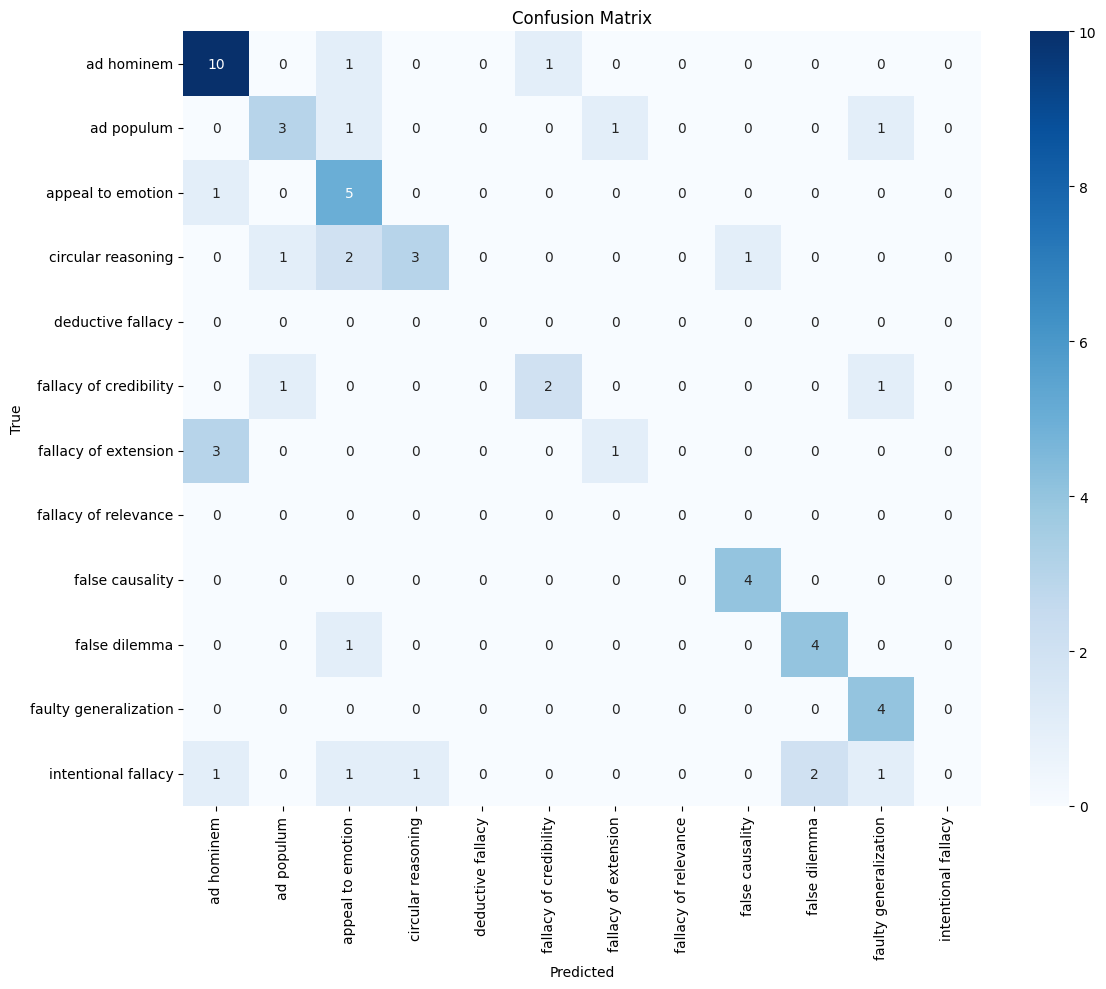

In [61]:
val_baseline_df = validation_predictions(batch_size=16)

In [ ]:
# Uncertainty estimation
print("Running training uncertainty analysis...")
N = 5
batch_size = 4
train_results = []

for i in tqdm(range(0, len(inputs_train), batch_size)):
    batch_inputs = inputs_train[i:i + batch_size]
    batch_labels = labels_train[i:i + batch_size]
    prompts = [detect_fallacy_prompt(arg) for arg in batch_inputs]
    responses = generate_batch_responses(prompts, batch_size=batch_size, num_return_sequences=N)
    grouped = [responses[j * N:(j + 1) * N] for j in range(len(batch_inputs))]
    for j, group in enumerate(grouped):
        disagreement, labels = calculate_disagreement(group)
        entropy = calculate_entropy(labels)
        consistency = reasoning_consistency(group)
        train_results.append({
            "index": i + j,
            "input": batch_inputs[j],
            "true_label": batch_labels[j],
            "responses": group,
            "predicted_labels": labels,
            "disagreement": disagreement,
            "entropy": entropy,
            "consistency": consistency
        })
    if i % (batch_size * 10) == 0:
        gc.collect()
        torch.cuda.empty_cache()

train_df = pd.DataFrame(train_results)
train_df.to_csv("/content/drive/MyDrive/266/train_metrics_final.csv", index=False)


Running training uncertainty analysis...


Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
 23%|██▎       | 186/810 [13:46<46:20,  4.46s/it]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdp

In [ ]:
# Top 10 most uncertain samples
train_df["inconsistency"] = 1 - train_df["consistency"]
top_entropy = train_df.sort_values("entropy", ascending=False).head(10)
top_disagreement = train_df.sort_values("disagreement", ascending=False).head(10)
top_inconsistency = train_df.sort_values("inconsistency", ascending=False).head(10)

top_entropy.to_csv("/content/drive/MyDrive/266/lfud_top_entropy.csv", index=False)
top_disagreement.to_csv("/content/drive/MyDrive/266/lfud_top_disagreement.csv", index=False)
top_inconsistency.to_csv("/content/drive/MyDrive/266/lfud_top_inconsistency.csv", index=False)


In [ ]:
top_entropy["true_label_str"] = top_entropy["true_label"].map(id2label)
top_disagreement["true_label_str"] = top_disagreement["true_label"].map(id2label)
top_inconsistency["true_label_str"] = top_inconsistency["true_label"].map(id2label)

In [ ]:
top_entropy_annotations = pd.DataFrame([
    (2088, "This is a deductive fallacy because it incorrectly assumes that the reporter’s belief about Julia Roberts transfers to the lady in the pink dress without confirming that the reporter knows the woman is Julia Roberts."),
    (1579, "This is an ad populum fallacy, appealing to popularity by suggesting the daughter should get an iPhone simply because everyone else has one."),
    (899, "This is a fallacy of relevance; the artistic appearance of crop circles is unrelated to the truth of extraterrestrial existence."),
    (2237, "This is a fallacy of extension, where one senator misrepresents the other's position against increased spending as wanting no defense at all."),
    (2009, "This is a fallacy of extension because it oversimplifies the opposing view as mere retribution, ignoring potentially valid arguments for capital punishment."),
    (631, "This is an appeal to emotion; it suggests disbelief in the game's outcome based on the players' passion rather than the actual rules or score."),
    (2234, "This is an ad populum fallacy that argues in favor of buying an iPhone based on the popularity among peers rather than the merits of the product."),
    (464, "This is a fallacy of extension; Person B distorts Person A’s simple statement into an exaggerated accusation of laziness."),
    (2047, "This is a faulty generalization because it draws a broad conclusion about society based on responses from a biased sample taken at a church."),
    (499, "This is an appeal to emotion by implying that disagreeing with the statement makes someone cold-hearted, rather than addressing the argument rationally."),
], columns=["index", "explanation"])

top_disagreement_annotations = pd.DataFrame([
    (1579, "This is an ad populum fallacy, relying on the popularity of iPhones among schoolchildren as justification for buying one, rather than on merit or need."),
    (2088, "This is a deductive fallacy because it assumes that the reporter's belief about Julia Roberts driving a Prius extends to the woman in the pink dress without confirming the identity link."),
    (680, "This is a fallacy of extension; the baker exaggerates the customer's comment about a cherry on top into a claim that the entire cake must be filled with cherries."),
    (464, "This is a fallacy of extension where Person B unfairly twists Person A’s neutral statement into a judgment about laziness."),
    (1012, "This is a fallacy of credibility; it suggests that because Tesla has critics, electric cars as a whole are not eco-friendly, which unfairly dismisses the broader argument based on selective authority."),
    (478, "This is an intentional fallacy, treating the joke's humor as something that must be objectively proven rather than being understood in context or subjectively."),
    (3022, "This is a fallacy of extension, where the second person distorts a reasonable suggestion about later school start times into an exaggerated and impractical proposal."),
    (2486, "This is a fallacy of relevance; the response relies on mysticism and theatrics rather than evidence, failing to logically support the claim about multiple dimensions."),
    (620, "This is a fallacy of extension; the second person grossly misrepresents a benign statement about pet policies as advocating for pest infestation."),
    (2237, "This is a fallacy of extension; the second senator distorts a call for fiscal responsibility into an accusation of wanting to leave the nation defenseless."),
], columns=["index", "explanation"])

top_inconsistency_annotations = pd.DataFrame([
    (1477, "This is a fallacy of credibility because it appeals to an authority figure who lacks relevant expertise on the topic, making the appeal unreliable."),
    (1846, "This is a fallacy of extension where the speaker uses an intentionally weak or exaggerated version of the opponent’s argument to easily ridicule or refute it."),
    (1523, "This is an ad hominem fallacy, focusing on the origin or history of an idea rather than evaluating its current meaning or merit."),
    (2860, "This is an ad hominem fallacy where the speaker attacks the person making the argument rather than addressing the content of the argument itself."),
    (1299, "This is a fallacy of extension because it misrepresents the opponent’s argument into a distorted version that’s easier to attack."),
    (1326, "This is an appeal to emotion where persuasion is attempted through emotional manipulation rather than logical reasoning."),
    (2911, "This is circular reasoning, where the conclusion is essentially a restatement of the premise, providing no actual proof."),
    (2582, "This is a fallacy of relevance where the content does not directly address the issue or question at hand, instead diverting attention."),
    (399, "This is an ad populum fallacy because it argues something must be true simply because many people believe it."),
    (2213, "This is an intentional fallacy, where a double standard or exception is argued without justification, misrepresenting intent or consistency."),
], columns=["index", "explanation"])


In [57]:
def create_examples_context(annotations_df, top_k):
    merged = pd.merge(top_k, annotations_df, on="index", how="inner")

    examples_context = [
        f"""Example argument: {row['input']}
Correct reasoning and fallacy: {row['explanation']}
Fallacy type: {row['true_label_str']}"""
        for _, row in merged.iterrows()
    ]

    return "\n\n".join(examples_context)

In [58]:
# Create active prompt
entropy_examples_context = create_examples_context(top_entropy, top_entropy_annotations)
disagreement_examples_context = create_examples_context(top_disagreement, top_disagreement_annotations)
inconsistency_examples_context = create_examples_context(top_inconsistency, top_inconsistency_annotations)

In [69]:
output_dir = "/content/drive/MyDrive/266"
# Save context to Google Drive
with open(f"{output_dir}/entropy_examples_context.txt", "w", encoding="utf-8") as f:
    f.write(entropy_examples_context)

with open(f"{output_dir}/disagreement_examples_context.txt", "w", encoding="utf-8") as f:
    f.write(disagreement_examples_context)

with open(f"{output_dir}/inconsistency_examples_context.txt", "w", encoding="utf-8") as f:
    f.write(inconsistency_examples_context)

Running validation: 100%|██████████| 90/90 [06:47<00:00,  4.52s/it]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", le


Validation Results - Few-shot Prompt
Accuracy: 0.1528

Classification Report:
                        precision    recall  f1-score   support

            ad hominem     0.7500    0.3488    0.4762        43
            ad populum     0.5000    0.0857    0.1463        35
     appeal to emotion     0.8000    0.1333    0.2286        30
    circular reasoning     0.8571    0.2609    0.4000        23
     deductive fallacy     0.2333    0.2593    0.2456        27
fallacy of credibility     0.5000    0.0833    0.1429        24
  fallacy of extension     0.2667    0.1481    0.1905        27
  fallacy of relevance     0.3333    0.0370    0.0667        27
       false causality     0.6667    0.1818    0.2857        33
         false dilemma     0.7143    0.2083    0.3226        24
 faulty generalization     0.4000    0.0465    0.0833        43
   intentional fallacy     0.0000    0.0000    0.0000        24
                  none     0.0000    0.0000    0.0000         0

              accuracy 

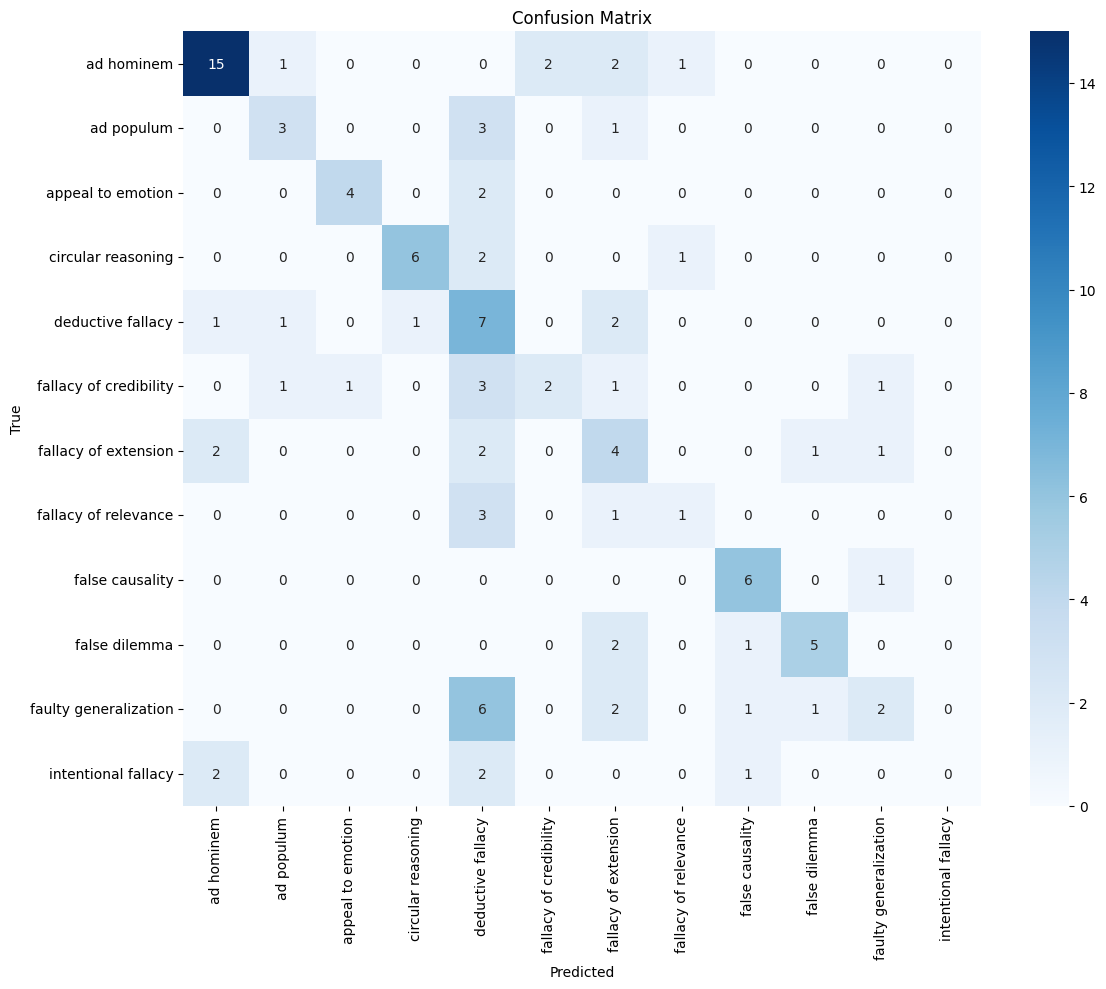

Running validation: 100%|██████████| 90/90 [06:45<00:00,  4.51s/it]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Validation Results - Few-shot Prompt
Accuracy: 0.1667

Classification Report:
                        precision    recall  f1-score   support

            ad hominem     0.7273    0.3721    0.4923        43
            ad populum     0.4444    0.3429    0.3871        35
     appeal to emotion     0.3333    0.0667    0.1111        30
    circular reasoning     1.0000    0.2609    0.4138        23
     deductive fallacy     0.0000    0.0000    0.0000        27
fallacy of credibility     0.6667    0.0833    0.1481        24
  fallacy of extension     0.2857    0.2222    0.2500        27
  fallacy of relevance     0.5000    0.0741    0.1290        27
       false causality     0.8889    0.2424    0.3810        33
         false dilemma     0.7143    0.2083    0.3226        24
 faulty generalization     0.1250    0.0233    0.0392        43
   intentional fallacy     0.0000    0.0000    0.0000        24
                  none     0.0000    0.0000    0.0000         0

              accuracy 

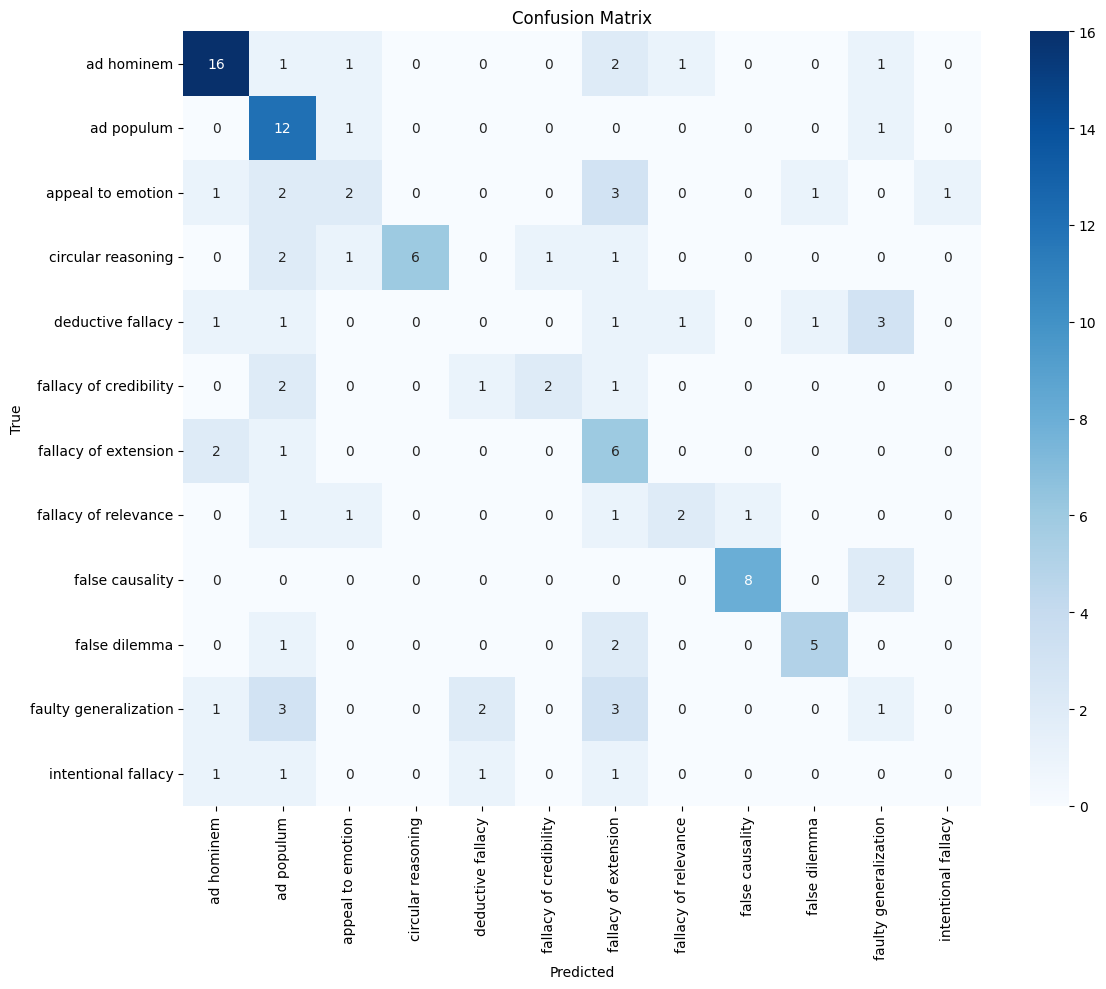

Running validation: 100%|██████████| 90/90 [06:42<00:00,  4.47s/it]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", le


Validation Results - Few-shot Prompt
Accuracy: 0.1750

Classification Report:
                        precision    recall  f1-score   support

            ad hominem     0.6897    0.4651    0.5556        43
            ad populum     0.8750    0.2000    0.3256        35
     appeal to emotion     0.6667    0.1333    0.2222        30
    circular reasoning     0.5000    0.0435    0.0800        23
     deductive fallacy     0.0000    0.0000    0.0000        27
fallacy of credibility     0.5000    0.1667    0.2500        24
  fallacy of extension     0.2400    0.2222    0.2308        27
  fallacy of relevance     0.5000    0.1481    0.2286        27
       false causality     0.6667    0.1818    0.2857        33
         false dilemma     0.6000    0.2500    0.3529        24
 faulty generalization     0.4545    0.1163    0.1852        43
   intentional fallacy     0.0000    0.0000    0.0000        24
                  none     0.0000    0.0000    0.0000         0

              accuracy 

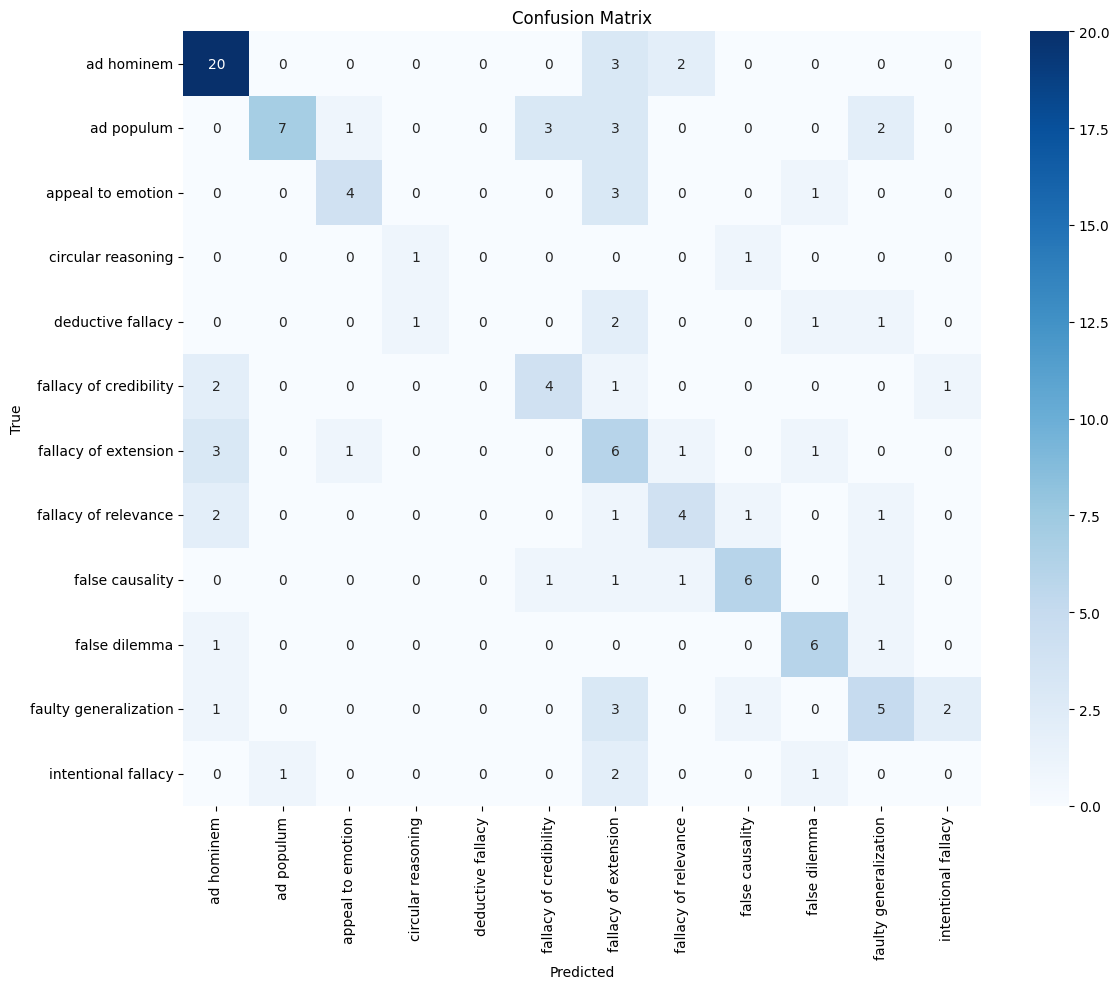

In [62]:
# Active prompting validation
val_entropy_df = validation_predictions(entropy_examples_context, batch_size=4)
val_disagreement_df = validation_predictions(disagreement_examples_context, batch_size=4)
val_inconsistency_df = validation_predictions(inconsistency_examples_context, batch_size=4)

In [63]:
# LogicClimate dataset evaluation
def evaluate_on_logic_climate(inputs, labels, examples_context=None, batch_size=4):
    results = []
    true_labels_str = [str(lbl).strip().lower() for lbl in labels]

    for i in tqdm(range(0, len(inputs), batch_size), desc="Running LogicClimate evaluation"):
        batch_inputs = inputs[i:i + batch_size]
        batch_labels = true_labels_str[i:i + batch_size]
        batch_prompts = [detect_fallacy_prompt(arg, examples_context) for arg in batch_inputs]
        responses = generate_batch_responses(batch_prompts, batch_size=batch_size, num_return_sequences=1)

        for j, r in enumerate(responses):
            results.append({
                "input": batch_inputs[j],
                "true_label": batch_labels[j],
                "predicted_label": extract_fallacy(r),
                "response": r
            })

    df = pd.DataFrame(results)
    print("\nEvaluation on LogicClimate Dataset:")
    evaluate_fallacy_predictions(df)
    return df

In [64]:
# Load and clean LogicClimate
logic_climate_all = pd.read_csv("https://raw.githubusercontent.com/causalNLP/logical-fallacy/main/data/climate_all.csv")
logic_climate_all.dropna(subset=['source_article', 'logical_fallacies'], inplace=True)
logic_climate_all['logical_fallacies'] = logic_climate_all['logical_fallacies'].replace({
    'intentional': 'intentional fallacy',
    'fallacy of logic': 'deductive fallacy'
})
logic_climate_all = logic_climate_all[logic_climate_all['logical_fallacies'] != 'equivocation']

logic_climate_inputs = logic_climate_all['source_article'].tolist()
logic_climate_labels = logic_climate_all['logical_fallacies'].tolist()


Running LogicClimate evaluation: 100%|██████████| 161/161 [11:42<00:00,  4.36s/it]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita


Evaluation on LogicClimate Dataset:
Accuracy: 0.0210

Classification Report:
                        precision    recall  f1-score   support

            ad hominem     0.2778    0.0521    0.0877        96
            ad populum     0.1429    0.0159    0.0286        63
     appeal to emotion     0.2069    0.0426    0.0706       141
    circular reasoning     0.0000    0.0000    0.0000         7
     deductive fallacy     0.0000    0.0000    0.0000        88
fallacy of credibility     0.3913    0.0687    0.1169       131
  fallacy of extension     0.0000    0.0000    0.0000        64
  fallacy of relevance     0.0909    0.0097    0.0175       103
       false causality     0.2143    0.0411    0.0690        73
         false dilemma     0.0000    0.0000    0.0000        49
 faulty generalization     0.0833    0.0075    0.0138       133
   intentional fallacy     1.0000    0.0030    0.0059       337
                  none     0.0000    0.0000    0.0000         0

              accuracy  

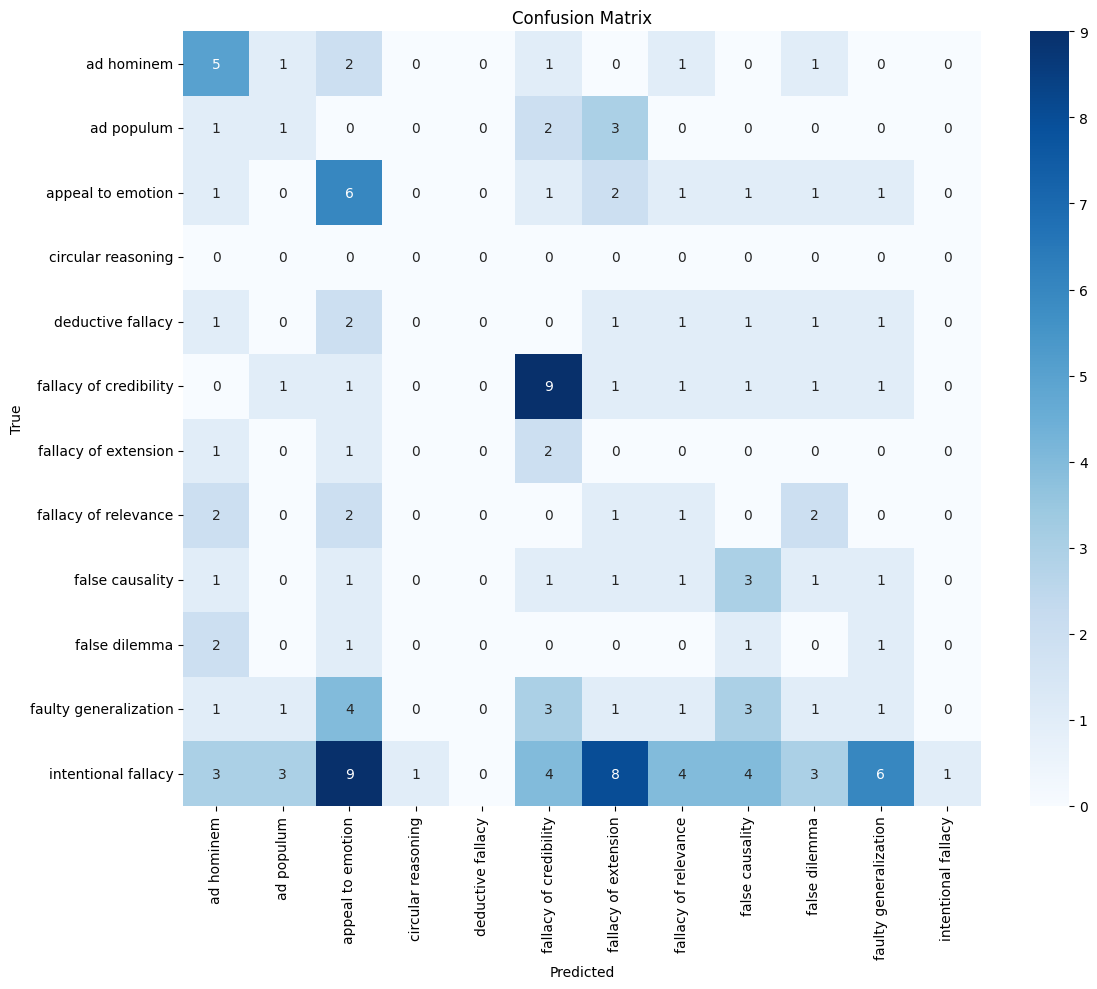

In [65]:
# Zero-shot baseline
logic_climate_baseline_df = evaluate_on_logic_climate(
    logic_climate_inputs, logic_climate_labels, examples_context=None, batch_size=8
)

Running LogicClimate evaluation: 100%|██████████| 322/322 [24:22<00:00,  4.54s/it]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len


Evaluation on LogicClimate Dataset:
Accuracy: 0.0358

Classification Report:
                        precision    recall  f1-score   support

            ad hominem     0.2432    0.0938    0.1353        96
            ad populum     0.0000    0.0000    0.0000        63
     appeal to emotion     0.3333    0.0355    0.0641       141
    circular reasoning     0.3333    0.1429    0.2000         7
     deductive fallacy     0.0741    0.0455    0.0563        88
fallacy of credibility     0.2381    0.0382    0.0658       131
  fallacy of extension     0.0526    0.0469    0.0496        64
  fallacy of relevance     0.0595    0.0485    0.0535       103
       false causality     0.1860    0.1096    0.1379        73
         false dilemma     0.3333    0.0612    0.1034        49
 faulty generalization     0.0571    0.0150    0.0238       133
   intentional fallacy     0.3333    0.0030    0.0059       337
                  none     0.0000    0.0000    0.0000         0

              accuracy  

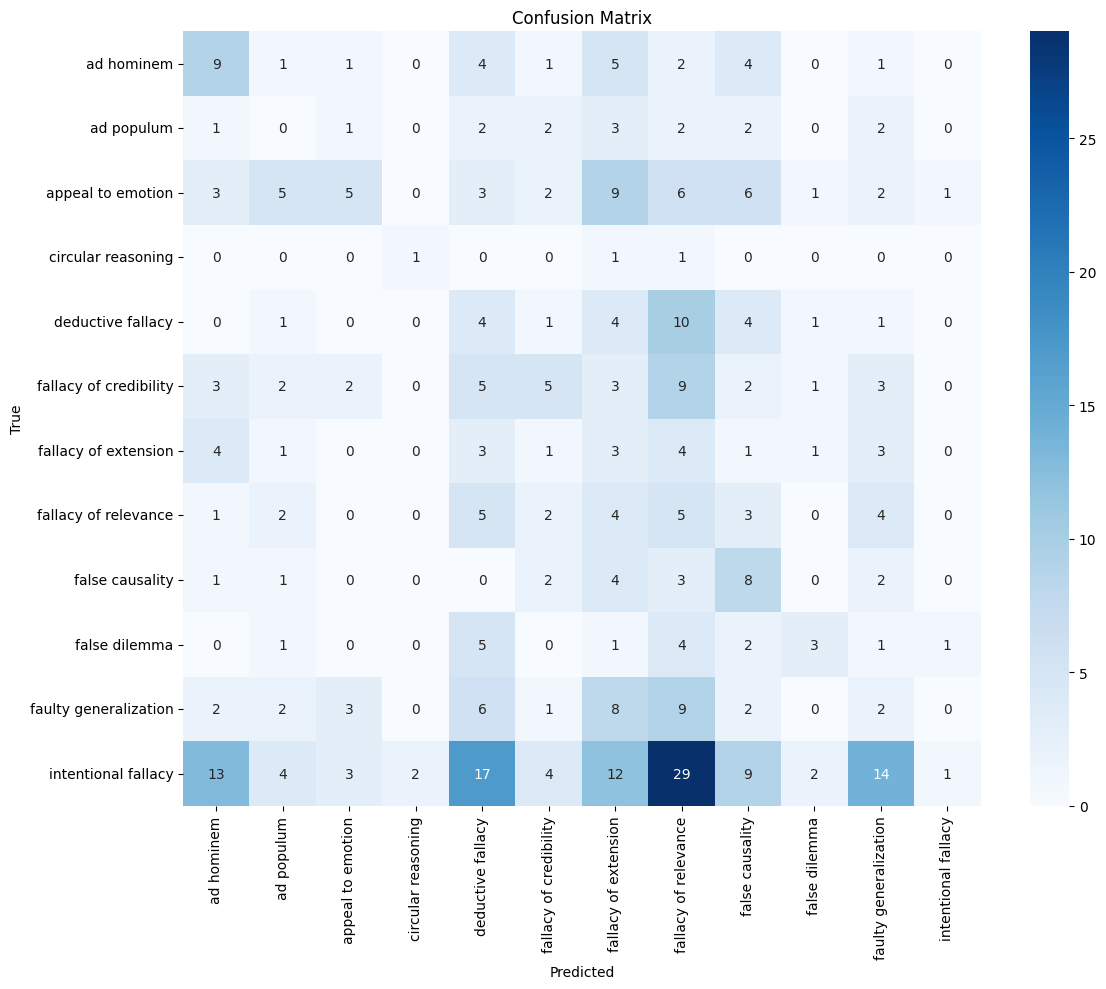

Running LogicClimate evaluation: 100%|██████████| 322/322 [24:23<00:00,  4.55s/it]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len


Evaluation on LogicClimate Dataset:
Accuracy: 0.0288

Classification Report:
                        precision    recall  f1-score   support

            ad hominem     0.2593    0.0729    0.1138        96
            ad populum     0.0294    0.0317    0.0305        63
     appeal to emotion     0.2500    0.0142    0.0268       141
    circular reasoning     0.0000    0.0000    0.0000         7
     deductive fallacy     0.1000    0.0114    0.0204        88
fallacy of credibility     0.4444    0.0916    0.1519       131
  fallacy of extension     0.0526    0.0781    0.0629        64
  fallacy of relevance     0.0833    0.0097    0.0174       103
       false causality     0.1818    0.0274    0.0476        73
         false dilemma     0.0000    0.0000    0.0000        49
 faulty generalization     0.0938    0.0226    0.0364       133
   intentional fallacy     0.3333    0.0059    0.0117       337
                  none     0.0000    0.0000    0.0000         0

              accuracy  

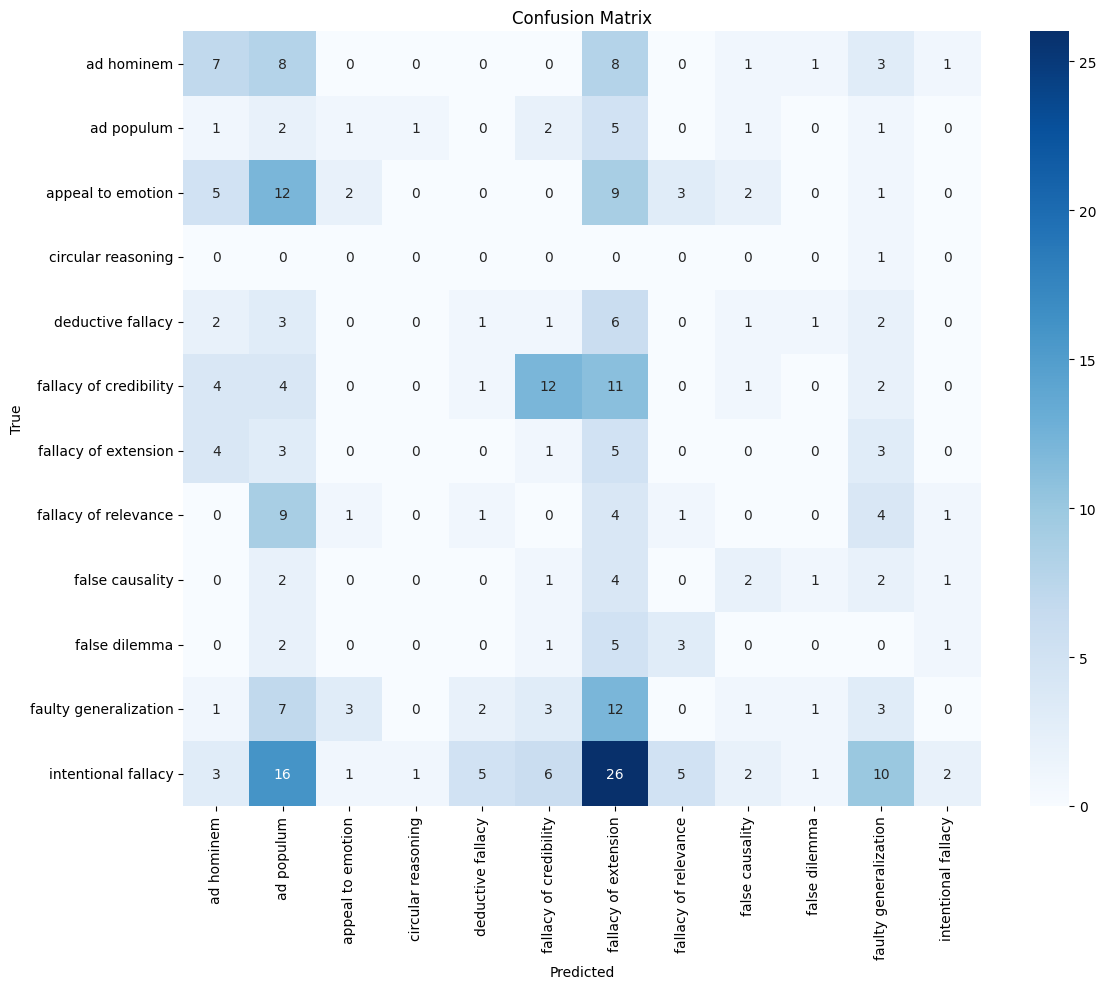

Running LogicClimate evaluation: 100%|██████████| 322/322 [23:54<00:00,  4.46s/it]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len


Evaluation on LogicClimate Dataset:
Accuracy: 0.0436

Classification Report:
                        precision    recall  f1-score   support

            ad hominem     0.3250    0.1354    0.1912        96
            ad populum     0.0000    0.0000    0.0000        63
     appeal to emotion     0.4483    0.0922    0.1529       141
    circular reasoning     0.0000    0.0000    0.0000         7
     deductive fallacy     0.0000    0.0000    0.0000        88
fallacy of credibility     0.1507    0.0840    0.1078       131
  fallacy of extension     0.0431    0.0781    0.0556        64
  fallacy of relevance     0.1389    0.0485    0.0719       103
       false causality     0.0870    0.0274    0.0417        73
         false dilemma     0.0000    0.0000    0.0000        49
 faulty generalization     0.1429    0.0451    0.0686       133
   intentional fallacy     0.2000    0.0030    0.0058       337
                  none     0.0000    0.0000    0.0000         0

              accuracy  

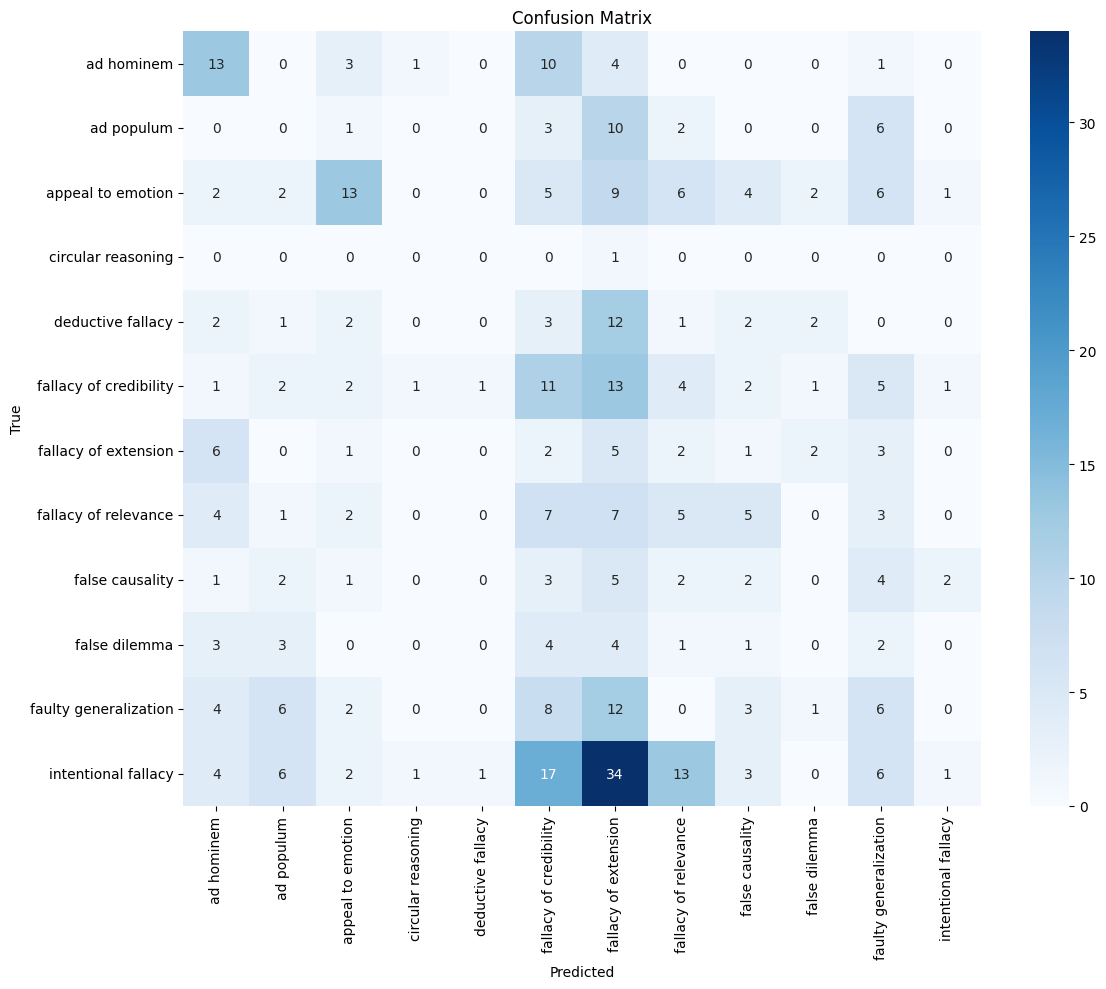

In [70]:
# Active prompting with entropy examples
logic_climate_entropy_df = evaluate_on_logic_climate(logic_climate_inputs, logic_climate_labels, examples_context=entropy_examples_context, batch_size=4)
logic_climate_disagreement_df = evaluate_on_logic_climate(logic_climate_inputs, logic_climate_labels, examples_context=disagreement_examples_context, batch_size=4)
logic_climate_inconsistency_df = evaluate_on_logic_climate(logic_climate_inputs, logic_climate_labels, examples_context=inconsistency_examples_context, batch_size=4)
